# Popularity based model

## Part 1: Import libraries and dataset

In [374]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
retail_data_original = pd.read_excel (r'D:/Internship-2020/ROBOKEN-internship/Recommendation-system/Datset/Online Retail Original.xlsx')

## Part 2: Cleaning and processing of the data

In [34]:
retail_data = retail_data_original
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Date,Time,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2010-12-01,08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,2010-12-01,08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2010-12-01,08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,2010-12-01,08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,2010-12-01,08:26:00,3.39,17850.0,United Kingdom


In [35]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   Date         541909 non-null  datetime64[ns]
 6   Time         541909 non-null  object        
 7   UnitPrice    541909 non-null  float64       
 8   CustomerID   406829 non-null  float64       
 9   Country      541909 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 41.3+ MB


### Table for Item name and its stock code

In [36]:
item_lookup = retail_data[['StockCode', 'Description']].drop_duplicates() # Only get unique item/description pairs
item_lookup['StockCode'] = item_lookup.StockCode.astype(str) # Encode as strings for future lookup ease

In [37]:
item_lookup.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [38]:
item_lookup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5752 entries, 0 to 540421
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StockCode    5752 non-null   object
 1   Description  4792 non-null   object
dtypes: object(2)
memory usage: 134.8+ KB


### Grouping purchase

Make a pivot table for every item, daywise sale

In [8]:
retail_data['StockCode'] = retail_data.StockCode.astype(str) # Convert to string for stock ID
retail_data = retail_data[['StockCode', 'Quantity', 'Time', 'Date','InvoiceDate']] # Get rid of unnecessary info
grouped_retail_buy_frequency = retail_data.groupby(['StockCode','Time', 'Date','InvoiceDate']).sum().reset_index() # Group together
grouped_retail_buy_frequency.Quantity.loc[grouped_retail_buy_frequency.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
# indicate purchased
grouped_purchased = grouped_retail_buy_frequency.query('Quantity > 0') # Only get customers where purchase totals were positive

C:\Users\test\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
grouped_purchased.head()

,StockCode,Time,Date,InvoiceDate,Quantity
0,10002,08:42:00,2010-12-06,2010-12-06 08:42:00,24
1,10002,08:45:00,2010-12-01,2010-12-01 08:45:00,48
2,10002,09:05:00,2011-01-19,2011-01-19 09:05:00,12
3,10002,09:09:00,2011-02-25,2011-02-25 09:09:00,24
4,10002,09:35:00,2010-12-13,2010-12-13 09:35:00,2


In [10]:
from pandas.api.types import CategoricalDtype
Products = list(np.sort(grouped_purchased.StockCode.unique())) # Get our unique products that were purchased
BuyDateandTime = list(grouped_purchased.InvoiceDate.unique()) # Get the date + time of purchase
BuyDate = list(grouped_purchased.Date.unique()) # Get the date of purchase
BuyTime = list(grouped_purchased.Time.unique()) # Get the Time of purchase
quantity = list(grouped_purchased.Quantity) # All of our purchases

#### Sparse plot for product vs date

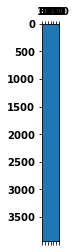

In [11]:
rows = grouped_purchased.StockCode.astype(CategoricalDtype(categories = Products)).cat.codes 
# Get the associated row indices
cols = grouped_purchased.Date.astype(CategoricalDtype(categories = BuyDate)).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(Products), len(BuyDate)))
plt.spy(purchases_sparse)

In [12]:
import numpy as np
from tabulate import tabulate

table = tabulate(purchases_sparse, tablefmt="grid")
print(purchases_sparse.shape[0])
print(purchases_sparse.shape[1])

3940
305


In [13]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

76.96296912706998

#### Sparse plot for products vs time

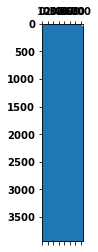

In [14]:
rows = grouped_purchased.StockCode.astype(CategoricalDtype(categories = Products)).cat.codes 
# Get the associated row indices
cols = grouped_purchased.Time.astype(CategoricalDtype(categories = BuyTime)).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(Products), len(BuyTime)))
plt.spy(purchases_sparse)

In [15]:
import numpy as np
from tabulate import tabulate

table = tabulate(purchases_sparse, tablefmt="grid")
print(purchases_sparse.shape[0])
print(purchases_sparse.shape[1])

3940
741


In [16]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

86.94571747604074

#### Sparse plot for product vs date and time

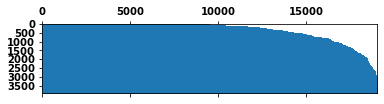

In [17]:
rows = grouped_purchased.StockCode.astype(CategoricalDtype(categories = Products)).cat.codes 
# Get the associated row indices
cols = grouped_purchased.InvoiceDate.astype(CategoricalDtype(categories = BuyDateandTime)).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(Products), len(BuyDateandTime)))
plt.spy(purchases_sparse)

In [18]:
import numpy as np
from tabulate import tabulate

table = tabulate(purchases_sparse, tablefmt="grid")
print(purchases_sparse.shape[0])
print(purchases_sparse.shape[1])

3940
19044


In [19]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.30903400833976

## Grouping purchase Daywise

#### Steps:
    1. Convert the string for stock ID
    2. Reduce unnecessary columns
    3. In case of zero purchase, update the value with 1 as it might be possible that someone has replaced it. Hence, 
    we want to focus only on the purchase
    4. For negative quantity, discard them

In [53]:
retail_data['StockCode'] = retail_data.StockCode.astype(str) # Convert to string for stock ID
retail_data = retail_data[['StockCode', 'Quantity', 'Time', 'Date','InvoiceDate']] # Get rid of unnecessary info
grouped_retail_buy_frequency = retail_data.groupby(['StockCode','Date']).sum().reset_index() # Group together
grouped_retail_buy_frequency.Quantity.loc[grouped_retail_buy_frequency.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
# indicate purchased
grouped_purchased = grouped_retail_buy_frequency.query('Quantity > 0') # Only get customers where purchase totals were positive

C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\test\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [54]:
grouped_purchased.head()

,StockCode,Date,Quantity
0,10002,2010-12-01,60
1,10002,2010-12-02,1
2,10002,2010-12-03,8
3,10002,2010-12-05,1
4,10002,2010-12-06,25


In [55]:
from pandas.api.types import CategoricalDtype
Products = list(np.sort(grouped_purchased.StockCode.unique())) # Get our unique products that were purchased
BuyDate = list(grouped_purchased.Date.unique()) # Get the date of purchase
quantity = list(grouped_purchased.Quantity) # All of our purchases

### Create sparse matrix to show the distribution between product and the date purchased

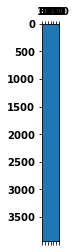

In [56]:
rows = grouped_purchased.StockCode.astype(CategoricalDtype(categories = Products)).cat.codes 
# Get the associated row indices
cols = grouped_purchased.Date.astype(CategoricalDtype(categories = BuyDate)).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(Products), len(BuyDate)))
plt.spy(purchases_sparse)

In [57]:
import numpy as np
from tabulate import tabulate

table = tabulate(purchases_sparse, tablefmt="grid")
print(purchases_sparse.shape[0])
print(purchases_sparse.shape[1])

3939
305


## 1. Basic popularity based recommendation

In [140]:
retail_data_new = grouped_purchased[['StockCode', 'Quantity']] # Get rid of unnecessary info

In [141]:
retail_data_new

,StockCode,Quantity
0,10002,60
1,10002,1
2,10002,8
3,10002,1
4,10002,25
...,...,...
280446,gift_0001_50,1
280447,gift_0001_50,1
280448,gift_0001_50,1
280449,gift_0001_50,1


In [154]:
retail_data_new_ = retail_data_new.groupby(['StockCode']).sum().reset_index()
retail_data_new_

,StockCode,Quantity
0,10002,1040
1,10080,495
2,10120,193
3,10123C,5
4,10124A,16
...,...,...
3934,gift_0001_20,20
3935,gift_0001_30,37
3936,gift_0001_40,3
3937,gift_0001_50,4


In [189]:
df = retail_data_new_
df_popular = df.sort_values(by=['Quantity'], ascending = False)

### Plot the frequency

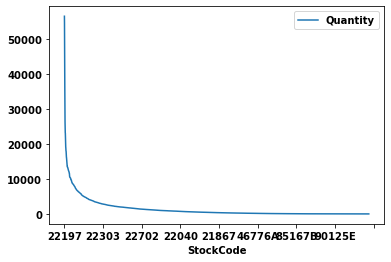

In [192]:
df_popular.plot(kind='line',x='StockCode',y='Quantity')
plt.show()

In [193]:
df_popular

,StockCode,Quantity
1112,22197,56450
2919,84077,54521
3402,85099B,47426
3422,85123A,39457
3206,84879,36264
...,...,...
3351,85036b,1
575,21414,1
2413,23595,1
3360,85044,1


Comvert to numpy array

In [202]:
new = np.array(df_popular)
new[2][0]

'85099B'

## Output for top # popular items 
### Category 1

Recommendation function

In [205]:
def rec_items( df, item_lookup, num_items):
    rec_list = []
    for i in range(num_items):
        code = df[i][0]
        rec_list.append([code, item_lookup.Description.loc[item_lookup.StockCode == code].iloc[0]])
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions}) # Create a dataframe 
    return final_frame[['StockCode', 'Description']] # Switch order of columns around
    return rec_list

Steps:
1. Enter the number of top recommendation you want
2. Press Shift + Enter

In [211]:
Num = int(input('Enter the number of top popular recommendations you want: ')) #Step 1
rec_items(new, item_lookup, Num)

Enter the number of top popular recommendations you want: 12


,StockCode,Description
0,22197,SMALL POPCORN HOLDER
1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
2,85099B,JUMBO BAG RED RETROSPOT
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER
4,84879,ASSORTED COLOUR BIRD ORNAMENT
5,21212,PACK OF 72 RETROSPOT CAKE CASES
6,23084,RABBIT NIGHT LIGHT
7,22492,MINI PAINT SET VINTAGE
8,22616,PACK OF 12 LONDON TISSUES
9,21977,PACK OF 60 PINK PAISLEY CAKE CASES


## 2. Popular this month

In [360]:
retail_data_V2 = retail_data[['StockCode', 'Quantity', 'Date']] # Get rid of unnecessary info
retail_data_V2

,StockCode,Quantity,Date
0,85123A,6,2010-12-01
1,71053,6,2010-12-01
2,84406B,8,2010-12-01
3,84029G,6,2010-12-01
4,84029E,6,2010-12-01
...,...,...,...
541904,22613,12,2011-12-09
541905,22899,6,2011-12-09
541906,23254,4,2011-12-09
541907,23255,4,2011-12-09


Latest date: 2011-12-09
Oldest date: 2010-12-01

In [ ]:
def last_n_days_sale(df, num_day):
    rows = len(retail_data_V2) # number of entries in the dataframe
    end_date = retail_data_V2.iat[rows-1,2] # latest date
    delta = timedelta(days=num_day)
    start_date = end_date - delta
    print("The record is being displayed for products bought between ("+ str(start_date) + ") and ("+ str(end_date) + ")")
    
    # segregating the day, month and year of the 
    start_day = start_date.day
    start_month = start_date.month
    start_year = start_date.year
    print(start_day, start_month, start_year)
    end_day = end_date.day
    end_month = end_date.month
    end_year = end_date.year
    print(end_day, end_month, end_year)

    df = retail_data_V2
    df2 = df[(df.Date >= datetime(start_year, start_month, start_day)) &
             (df.Date <= datetime(end_year, end_month, start_day))]
    df2

In [352]:
rows = len(retail_data_V2)
print(retail_data_V2.iat[rows-1,2])
end_date = retail_data_V2.iat[rows-1,2]

2011-12-09 00:00:00


In [353]:
from datetime import datetime, timedelta
print("Today's date:", date.today())

delta = timedelta(days=30)
start_date = end_date - delta
print("The record is being displayed for products bought between ("+ str(start_date) + ") and ("+ str(end_date) + ")")

Today's date: 2020-08-21
The record is being displayed for products bought between (2011-11-09 00:00:00) and (2011-12-09 00:00:00)


In [356]:
start_day = start_date.day
start_month = start_date.month
start_year = start_date.year
print(start_day, start_month, start_year)
end_day = end_date.day
end_month = end_date.month
end_year = end_date.year
print(end_day, end_month, end_year)

df = retail_data_V2
df2 = df[(df.Date >= datetime(start_year, start_month, start_day)) &
         (df.Date <= datetime(end_year, end_month, start_day))]
df2

9 11 2011
9 12 2011


,StockCode,Quantity,Date
451127,21035,100,2011-11-09
451128,20685,10,2011-11-09
451129,23110,4,2011-11-09
451130,21485,3,2011-11-09
451131,22558,12,2011-11-09
...,...,...,...
541904,22613,12,2011-12-09
541905,22899,6,2011-12-09
541906,23254,4,2011-12-09
541907,23255,4,2011-12-09


In [365]:
df2 = df2.groupby(['StockCode']).sum().reset_index()
df2.Quantity.loc[grouped_retail_buy_frequency.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
# indicate purchased
df2 = df2.query('Quantity > 0') # Only get customers where purchase totals were positive
df2

C:\Users\test\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,StockCode,Quantity
0,10080,89
1,10120,17
2,10125,86
3,10135,188
4,11001,133
...,...,...
2900,DCGSSGIRL,1
2901,DOT,54
2902,M,3655
2903,POST,1273


In [366]:
df2_popular = df2.sort_values(by=['Quantity'], ascending = False)

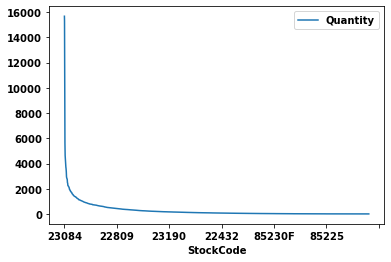

In [367]:
df2_popular.plot(kind='line',x='StockCode',y='Quantity')
plt.show()

In [368]:
df2_popular

,StockCode,Quantity
1584,23084,15681
834,22197,15303
2441,84826,12643
742,22086,7626
2455,84879,5656
...,...,...
2660,90011C,1
2661,90011D,1
2669,90016C,1
2679,90024F,1


In [372]:
new = np.array(df2_popular)
new[2][0]

'84826'

In [373]:
Num = int(input('Enter the number of top popular recommendations you want: ')) #Step 1
rec_items(new, item_lookup, Num)

Enter the number of top popular recommendations you want: 2


,StockCode,Description
0,23084,RABBIT NIGHT LIGHT
1,22197,SMALL POPCORN HOLDER
